In [1]:
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.prebuilt import create_react_agent
from langgraph.types import Command
from typing import Literal
from typing_extensions import TypedDict

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0, api_key="", model="gpt-4o-mini")

In [3]:
import chromadb

client = chromadb.PersistentClient(path="chroma_db")
collection = client.get_collection("pharma-kb")


In [4]:
def search_pharma_kb(query, top_n=10):
    results = collection.query(
        query_texts=[query],
        n_results=top_n
    )

    return {"documents": results["documents"]}

In [5]:
from langchain.tools import Tool
search_pharma_kb_tool = Tool(
    name="pharma_kb_search",
    func=search_pharma_kb,
    description="Pharamaceutical knowledge base"
)

In [6]:
qa_agent = create_react_agent(
    model=llm,
    tools=[search_pharma_kb_tool],
    prompt="You are a pharmaceutical expert specializing in answering user questions about medication, composition, dosage, and side effects. Use the pharma knowledge base to retrieve relevant information and answer the user's questions in a detailed, natural language format. Provide references from the dataset when necessary. Just use the chunks from the knowledge to answer."
)

In [7]:
recommender_agent = create_react_agent(
    model=llm,
    tools=[search_pharma_kb_tool],
    prompt="You are a pharmaceutical expert in recommending medications. Based on user symptoms or conditions, recommend the appropriate medication while warning about possible harmful combinations or contraindications. Use the pharma knowledge base to retrieve relevant details and ensure your recommendations are safe and personalized. Just use the chunks from the knowledge to answer."
)

In [8]:
alternatives_agent = create_react_agent(
    model=llm,
    tools=[search_pharma_kb_tool],
    prompt="You are an expert in pharmaceutical alternatives. Based on user queries, suggest safe alternatives for medications. Use the pharma knowledge base to ensure the alternatives are appropriate and explain any differences in effects, risks, and usage instructions. Just use the chunks from the knowledge to answer."
)

In [9]:
summarizer_agent = create_react_agent(
    model=llm,
    tools=[search_pharma_kb_tool],
    prompt="You are an expert at summarizing pharmaceutical products. Provide a concise and clear summary of the product's key details, including its purpose, administration instructions, side effects, and warnings. Use the pharma knowledge base for accurate information. Just use the chunks from the knowledge to answer."
)

In [10]:
members = ["qa-agent", "recommender-agent", "alternatives-generator", "summarizer-agent"]

options = members + ["Finish"]

class State(MessagesState):
    next:str

class Router(TypedDict):
    next: Literal[*options]



system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Based on the user's request, determine"
    " which worker (qa-agent, recommender-agent, alternatives-generator,"
    " summarizer-agent) should handle the task. Each worker specializes in"
    " different aspects: the qa-agent answers questions about medications, "
    " the recommender-agent suggests medications, the alternatives-generator"
    " suggests alternatives, and the summarizer-agent provides product"
    " summaries. Choose the best worker to handle the task. If the task is complete,"
    " respond with 'Finish'."
)


def supervisor_node(state:State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt}
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "Finish":
        goto = END
    
    return Command(goto=goto, update={"next": goto})

def qa_node(state: State) -> Command[Literal["supervisor"]]:
    result = qa_agent.invoke(state)
    return Command(
        update={
            "messages":[
                HumanMessage(content=result["messages"][-1].content, name="qa-agent")
            ]
        },
        goto="supervisor"
    )

def recommender_node(state:State) -> Command[Literal["supervisor"]]:
    result = recommender_agent.invoke(state)
    return Command(
        update= {
            "messages":[
                HumanMessage(content=result["messages"][-1].content, name="recommender-agent")
            ]
        },
        goto="supervisor"
    )

def alternatives_node(state:State) -> Command[Literal["supervisor"]]:
    result = alternatives_agent.invoke(state)
    return Command(
        update={
            "messages":[
                HumanMessage(content=result["messages"][-1].content,
                name="alternatives-generator")
            ]
        },
        goto="supervisor"
    )

def summarizer_node(state:State) -> Command[Literal["supervisor"]]:
    result = summarizer_agent.invoke(state)
    return Command(
        update={
            "messages":[
                HumanMessage(content=result["messages"][-1].content,
                name="summarizer-agent")
            ]
        },
        goto="supervisor"
    )

builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("qa-agent", qa_node)
builder.add_node("recommender-agent", recommender_node)
builder.add_node("alternatives-generator", alternatives_node)
builder.add_node("summarizer-agent", summarizer_node)
graph = builder.compile()

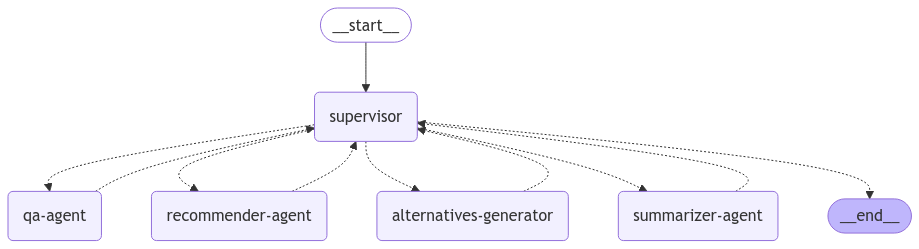

In [11]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
for s in graph.stream(
    {
        "messages": [
            (
                "user",
                "What are the side effects of taking aspirin?",
            )
        ]
    },
    subgraphs=True,
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'qa-agent'}})
----
(('qa-agent:df3bc695-f057-3523-d91b-9f09c8c09a64',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_sxIty13V0huLfvy2jB0PVNXL', 'function': {'arguments': '{"__arg1":"aspirin side effects"}', 'name': 'pharma_kb_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 122, 'total_tokens': 145, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4dc72d7d-1dba-4bde-91bd-77a9305b4e4a-0', tool_calls=[{'name': 'pharma_kb_search', 'args': {'__arg1': 'aspirin side effects'}, 'id': 'call_sxIty13V0huLfvy2jB0PVNXL', 'type': 'tool_call'}], usage_metadat